In [1]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsd,gsd.hoomd
import gsd.pygsd
import seaborn as sns
from scipy.interpolate import interp1d
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import warnings
warnings.filterwarnings('ignore')

2 Physical GPUs, 2 Logical GPUs


### Prequisites

This code requires the `gsd`, `seaborn` and `scipy` packages.

In this example we will run a coarse-grained (CG) simulation using the HOOMD-blue simulation engine. A 2-bead CG methanol system with 1000 CG molecules will be used. Bonded interactions will be approximated with a harmonic function. Boltzmann inverted radial distribution function will be used as the non-bonded pair potential. All-atom RDFs and positions from example 02 are used here. The all atom trajectory is saved in `CG_tutorial/meth_traj.gsd`. The goal of this notebook is to set up the basic tools needed to run a CG simulation using the Iterative Boltzmann Inverted (**IBI**) method.

![CG_methanol.png](CG_tutorial/CG_methanol.png)

## Step 1: Boltzmann inversion of the radial distribution function (RDF) to compute the non-bonded pair potentials
First we will compute the potentials and forces arising from the non-bonded interactions according to the following equations. These will be used in step 2 to run the CG-simulation

<img src="https://render.githubusercontent.com/render/math?math=U^{CG}(pair) = -K_BT \ln(g(r))">
<img src="https://render.githubusercontent.com/render/math?math=F^{CG}(pair) = -\frac{d(U^{CG}(pair))}{d(r)}">
<img src="https://render.githubusercontent.com/render/math?math=g(r): \textrm{RDF}">

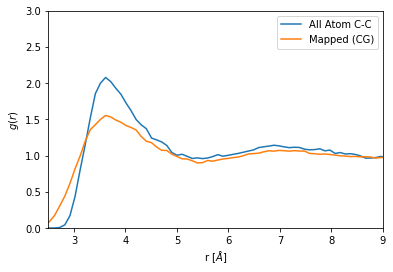

In [2]:
# For the computation of AA-RDF and CG-RDF please refer to example 02.
aa_rdf = np.load('CG_tutorial/aa_rdf.npy')
cg_rdf = np.load('CG_tutorial/cg_rdf.npy')
r = aa_rdf[1,:]
plt.plot(aa_rdf[1,:], aa_rdf[0,:] / aa_rdf[0,-1],label ='All Atom C-C')
plt.plot(cg_rdf[1,:], cg_rdf[0,:] / cg_rdf[0,-1], label='Mapped (CG)')
plt.xlim(2.5,9)
plt.ylim(0,3)
plt.xlabel(r'r [$\AA$]')
plt.ylabel('$g(r)$')
plt.legend()
plt.show()

Next we compute the bonded atom indices using `compute_cg_graph` and `mol_features_multiple` functions implemented in HTF. The adjacency matrix stores the connectivities of the CG beads. 

In [3]:
adjacency_matrix = np.array([[0,1],[1,0]])

bonds,angs,dihes = htf.compute_cg_graph(DSGPM=False,adj_mat=adjacency_matrix,group_atoms=False)

bond_ids,ang_ids,dihe_ids = htf.mol_features_multiple(bonds,molecules=1000,beads=2)


CG coordinates are not caculated. Only connectivities are calculated


Now we will do the Boltzmann inversion of the RDF to compute the non-bonded pair potential.

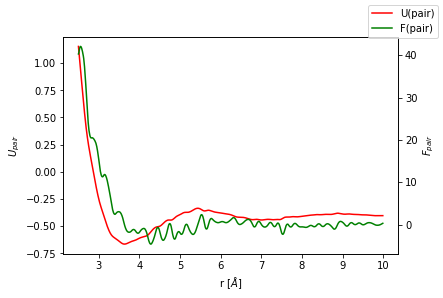

In [4]:
kb = 1.9872/1000 #Boltzmann constant in kcal/(mol.K) units
T = 300. # Temp in K units
gr = cg_rdf[0,:]/np.mean(cg_rdf[-10:])
r = cg_rdf[1,:]
#ugr = -T*kb*np.log(gr)

#smoothen the inverted potential
smooth = interp1d(r,gr,kind='cubic',fill_value = "extrapolate")
rmin = 2.5
rmax = 10.0
r_smooth = np.arange(rmin,rmax,0.01)
gr_smooth = smooth(r_smooth)
pair_pot = -T*kb*np.log(gr_smooth)
pair_force = -np.gradient(pair_pot,0.001)

# Plot potential energy 
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(r_smooth,pair_pot,color='r',label='U(pair)')
ax1.set_ylabel('$U_{pair}$')
ax1.set_xlabel(r'r [$\AA$]')
ax2.plot(r_smooth,pair_force,color='g',label='F(pair)')
ax2.set_ylabel('$F_{pair}$')
fig.legend()
fig.show()

Potential energies and forces are saved to `CG_tutorial/BI_pair_potential.dat`. These will be later used in the HOOMD-blue simulation. 

In [5]:
col_format = "{0:5.3f}"+"{1:10.4f}"+"{2:10.4f}" + '\n'

with open('CG_tutorial/BI_pair_potential.dat','w') as outfile:
    for items in zip(r_smooth,pair_pot,pair_force):
        outfile.write(col_format.format(*items))

### Next we'll calculate properties needed for the harmonic potential implementation

Harmonic potential function is given by the equation:

$$ U^{CG}(bonds) = \frac{1}{2} k_{bond}(r-r_0)$$

Here $k_{bond}$ is the bond coefficient and $r_0$ is the bond rest length. We can compute these using the CG bond distribution. CG positions used here are the center-of-mass positions for each bead mapped from the AA simulation. These are saved in `CG_tutorial/meth_CGtraj_positions.npy`. Dimensions of the box can be found using MDAnalysis.

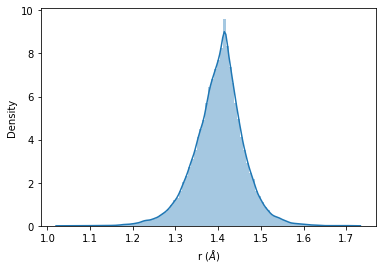

In [6]:
box=np.array([[-20.4471, -20.4471, -20.4471],[20.4471, 20.4471, 20.4471],[0, 0, 0]],dtype=np.float32)
cg_positions = np.load('CG_tutorial/meth_CGtraj_positions.npy')
bond_distribution = []
for frame in range(cg_positions.shape[0]):
    cg_r = []
    for i in range(len(bond_ids)):
        cg_dist = htf.mol_bond_distance(CG = True, cg_positions = cg_positions[frame],
                                     b1=bond_ids[i][0],b2=bond_ids[i][1],box=box)
        cg_r.append(cg_dist)
        
    bond_distribution.append(cg_r)

## Plot the bond distribution 
bond_data = np.array(bond_distribution).reshape((-1))
fig = sns.distplot(bond_data,bins=100,kde=True) 
fig.set(xlabel='r ($\AA$)')
plt.show()

<img src="https://render.githubusercontent.com/render/math?math=k_{bond} = \frac{K_BT}{Var(\vec{r})}">
<img src="https://render.githubusercontent.com/render/math?math=r_0 = Mean(\vec{r})">
<img src="https://render.githubusercontent.com/render/math?math=\vec{r} : \textrm{bond distance}, K_B : \textrm{Boltzmann constant}">

In [7]:
r_vec= np.sort(bond_data)
r0 = np.mean(r_vec)
kr = (kb*T/np.var(r_vec)) 
print('r0: ',r0,'bond constant:',kr)

r0:  1.40191 bond constant: 171.71954922166913


# Step 2: CG simulation using HOOMD-blue

In [9]:
hoomd.context.initialize('')
s = hoomd.data.make_snapshot(N=2000,box= hoomd.data.boxdim(L=1000),particle_types=['CG'],
                              bond_types=['B1']) #We consider only one type of bead here
s.particles.position[:] = np.load('CG_tutorial/meth_CGtraj_positions.npy')[0]
s.particles.typeid[:] = 0
s.bonds.resize(bond_ids.shape[0])
s.bonds.group[:] = bond_ids
c = hoomd.context.initialize('--gpu=1')
system = hoomd.init.read_snapshot(s)
set_rcut = 10.0

# Set system potentials

nlist = hoomd.md.nlist.cell()
nlist.reset_exclusions(['bond'])
bharm = hoomd.md.bond.harmonic(name='bonds')
# Use the Harm bond coefficients computed above
bharm.bond_coeff.set('B1',k=kr,r0=r0) 
# We will read the non-bonded energies and forces saved above
# width=num_lines in the file
pairtable = hoomd.md.pair.table(width=750, nlist=nlist) 
pairtable.set_from_file('CG','CG',filename='CG_tutorial/BI_pair_potential.dat')

#=============NVE Simulation=============================
group_all = hoomd.group.all()
kT = 1.9872/1000

timestep = 10/489.9
im = hoomd.md.integrate.mode_standard(dt=timestep)
nve = hoomd.md.integrate.nve(group=group_all)
nve.randomize_velocities(seed=1234,kT=298.15 * kT)
#Log statement:
#hoomd.analyze.log(filename='CG_tutorial/METH_CG.log',quantities = ['potential_energy', 'kinetic_energy'],
#                  period=10,overwrite=True,header_prefix='#')
hoomd.run(500)

*Warning*: Ignoring new options, cannot change execution mode after initialization.


notice(2): Group "all" created containing 2000 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:06 | Step 500 / 500 | TPS 81.5318 | ETA 00:00:00
Average TPS: 81.5168
---------
-- Neighborlist stats:
269 normal updates / 2 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 177 / n_neigh_avg: 108.489
shortest rebuild period: 1
-- Cell list stats:
Dimension: 96, 96, 96
n_min    : 0 / n_max: 44 / n_avg: 0.00226056
** run complete **


If a user prefers to implement the IBI method to improve the structural data (RDF in this case) from the CG simulation, the non-bonded pair potential can be updated iteratively according to the following equation:

<img src="https://render.githubusercontent.com/render/math?math=U_{(t+1)}= U_t + K_BT \frac{g(r)_{CG}}{g(r)_{target} }">
<img src="https://render.githubusercontent.com/render/math?math=U_0: -K_BT \ln(g(r)_{target})">
<img src="https://render.githubusercontent.com/render/math?math=g(r)_{target}: \mathrm{Mapped RDF from the AA simulation}">